# Predicting Bike Rentals
Bike sharing has become popular in large U.S. communities over the last five years. Washington D.C. is a city with a bike sharing program, and they collect data on the number of bicycles people rent by the hour and day. 

This project attempts to predict the total number of bikes rented in a given hour by evaluating the performance of the following machine learning models and experimenting with their parameters:
- Linear regression model with the top 5 strongest correlating features
- Linear regression model with the addition of three more features
- Decision tree regressor model with default settings
- Decision tree regressor model with min_sample_leaf i = 1-20
- Decision tree regressor model with max depth i = 1-20
- Decision tree regressor model with max leaf nodes i = 2-20
- Random forest regressor model with n_estimators = 150, min_sample_leaf = 5
- Random forest regressor model with min sample leaf i = 100-500

### Project Purpose
This project is for the completion of the DataQuest.io https://www.dataquest.io/ "Machine Learning in Python:Intermediate" module; the twenty-fifth in a series for completing the Data Science course path.

### Summary Results
Random forest regressor model with n_estimators = 150, min_sample_leaf = 5 returned the best RMSE value of 93.13

# Data Source and Exploration

The compiled by Hadi Fanaee_T at the University of Porto in Portugal. It can be downloaded from the [University of California, Irvine's Website.](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. The relevant columns and their descriptions are as follows:

|Column|Description|
|:------|:-----|
|instant|A unique sequential ID number for each row|
|dteday| The date of the rentals|
|season|The season in which the rentals occurred|
|yr|The year the rentals occurred|
|mnth| The month the rentals occurred|
|hr|The hour the rentals occurred|
|holiday|Whether or not the day was a holiday|
|weekday|The day of the week (as a number, 0 to 7)|
|workingday| Whether or not the day was a working day|
|weathersit| The weather (as a categorical variable)|
|temp|The temperature, on a 0-1 scale|
|atemp|The adjusted temperature|
|hum| The humidity, on a 0-1 scale|
|windspeed|The wind speed, on a 0-1 scale|
|casual| The number of casual riders (people who hadn't previously signed up with the bike sharing program)|
|registered|The number of registered riders (people who had already signed up)|
|cnt|The total number of bike rentals (casual + registered)|

In [293]:
#import the python libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [308]:
bikes = pd.read_csv('bike_rental_hour.csv', index_col= 'instant')
bikes.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [295]:
bikes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17379 entries, 1 to 17379
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      17379 non-null  object 
 1   season      17379 non-null  int64  
 2   yr          17379 non-null  int64  
 3   mnth        17379 non-null  int64  
 4   hr          17379 non-null  int64  
 5   holiday     17379 non-null  int64  
 6   weekday     17379 non-null  int64  
 7   workingday  17379 non-null  int64  
 8   weathersit  17379 non-null  int64  
 9   temp        17379 non-null  float64
 10  atemp       17379 non-null  float64
 11  hum         17379 non-null  float64
 12  windspeed   17379 non-null  float64
 13  casual      17379 non-null  int64  
 14  registered  17379 non-null  int64  
 15  cnt         17379 non-null  int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 2.3+ MB


# Feature Selection
The casual and registered columns are redundant to the count column since the count column is derived by the sum of the two. The main focus is on temperature, average temperature, hour and year since those five features have the strongest correlation without being redundant; based on the results of the correlation and heat maps below.

<AxesSubplot:>

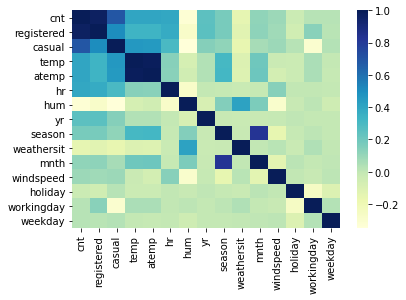

In [296]:
# Find the columns that correlate the closest to 'cnt'
bikes_corr = bikes.corr()
cnt_corr = bikes_corr['cnt'].abs().sort_values(ascending= False)
# Create a heatmap
corr_map = bikes[cnt_corr.index]
sns.heatmap(corr_map.corr(), cmap="YlGnBu")

In [297]:
# Keep only features that have a correlation of 0.3 or higher 
strong_corr = cnt_corr[(cnt_corr < 0.5) & (cnt_corr > 0.25)]
print('The features with the strongest correlation to count are: \n {}'.format(strong_corr[:])) 

The features with the strongest correlation to count are: 
 temp     0.404772
atemp    0.400929
hr       0.394071
hum      0.322911
yr       0.250495
Name: cnt, dtype: float64


# Assigning Values to Categorical Data
Hour has a strong correlation to count; but, in order to make more practical sense of this column containing values from 1 to 24, they are grouped and relabeled into 4 numerical values to represent the following: 
 - 1 = 'morning'
 - 2 = 'afternoon'
 - 3 = 'evening'
 - 4 = 'night' 

In [298]:
def assign_label(hour):
    if hour >= 6 and hour < 12:
        return 1
    elif hour >= 12 and hour < 18:
        return 2
    elif hour >= 18 and hour < 24:
        return 3
    else: 
        return 4

bikes['time_label'] = bikes['hr'].apply(assign_label)
bikes['time_label'].value_counts()  

2    4375
3    4368
1    4360
4    4276
Name: time_label, dtype: int64

# Splitting the Data into Training and Testing Data Frames

### Selecting the Metric
The metric to use to evaluate performance of machine learning algorithm is mean squared error because it's not binary and  As, we take square of the error, the effect of larger errors become more pronounced then smaller error, hence the model can now focus more on the larger errors.


In [299]:
# Use pandas DataFrame.sample() to split train and test data 80:20 (train:test)
train = bikes.sample(frac=.8)
test = bikes.loc[~bikes.index.isin(train.index)]

### The Linear Regression Model with the Top 5 Strongest Correlating Features

In [300]:
cols = ['temp','atemp','hr','hum','yr']
target = ['cnt']
lr = LinearRegression()
lr.fit(train[cols], train[target])
prediction = lr.predict(test[cols])
mse = mean_squared_error(test[target], prediction)
rmse = np.sqrt(mse).round(3)
print('The RMSE value is: {}'.format(rmse))

The RMSE value is: 142.665


### The Linear Regression Model with the Addition of Three More Features

In [301]:
cols = ['temp','atemp','hr','hum','yr','time_label','season', 'weathersit']
target = ['cnt']
lr = LinearRegression()
lr.fit(train[cols], train[target])
prediction = lr.predict(test[cols])
mse = mean_squared_error(test[target], prediction)
rmse = np.sqrt(mse).round(3)
print('The RMSE value is: {}'.format(rmse))

The RMSE value is: 131.55652916543488


### Decision Tree Regressor Model with Default Settings

In [302]:
cols = ['temp','atemp','hr','hum','yr']
dtr = DecisionTreeRegressor()
dtr.fit(train[cols], train[target])
prediction = dtr.predict(test[cols])
mse = mean_squared_error(test[target], prediction)
rmse = np.sqrt(mse).round(3)
print('The RMSE value is: {}'.format(rmse))

The RMSE value is: 123.145


### Decision Tree Regressor Model with Min_Sample_Leaf i = 1-20

In [303]:
rmse = {}
for i in range(1,20):
    dtr = DecisionTreeRegressor(min_samples_leaf = i)
    dtr.fit(train[cols], train[target])
    prediction = dtr.predict(test[cols])
    mse = mean_squared_error(test[target], prediction)
    rmse[i] = (np.sqrt(mse)).round(3)
    min_val = min(rmse.values()) 
    min_key = [k for k, v in rmse.items() if v == min_val][0]
print('The best RMSE is {} with min sample leaf = {}'.format(min_val, min_key))

The best RMSE is 93.922 with min sample leaf = 15


### Decision Tree Regressor Model with Max Depth i = 1-20

In [304]:
rmse = {}
for i in range(1,20):
    dtr = DecisionTreeRegressor(max_depth = i)
    dtr.fit(train[cols], train[target])
    prediction = dtr.predict(test[cols])
    mse = mean_squared_error(test[target], prediction)
    rmse[i] = (np.sqrt(mse)).round(3)
    min_val = min(rmse.values()) 
    min_key = [k for k, v in rmse.items() if v == min_val][0]
print('The best RMSE is {} with max depth = {}'.format(min_val, min_key))

The best RMSE is 94.627 with max depth = 10


### Decision Tree Regressor Model with Max Leaf Nodes i = 2-20

In [305]:
rmse = {}
for i in range(2,20):
    dtr = DecisionTreeRegressor(max_leaf_nodes = i)
    dtr.fit(train[cols], train[target])
    prediction = dtr.predict(test[cols])
    mse = mean_squared_error(test[target], prediction)
    rmse[i] = (np.sqrt(mse)).round(3)
    min_val = min(rmse.values()) 
    min_key = [k for k, v in rmse.items() if v == min_val][0]
print('The best RMSE is {} with max leaf nodes = {}'.format(min_val, min_key))

The best RMSE is 105.846 with max leaf nodes = 19


### Random Forest Regressor Model with n_estimators = 150, min_sample_leaf = 5

In [309]:
rfr = RandomForestRegressor(n_estimators=150, random_state= 1, min_samples_leaf= 5)
rfr.fit(train[cols], train[target].values.ravel())
prediction = rfr.predict(test[cols])
mse = mean_squared_error(test[target], prediction)
rmse = (np.sqrt(mse)).round(3)
print('The RMSE value is: {}'.format(rmse))

The RMSE value is: 101.985


### Random Forest Regressor Model with Min Sample Leaf i = 100-500

In [307]:
rmse = {}
for i in range(100,500):
    rfr = RandomForestRegressor(min_samples_leaf = i)
    rfr.fit(train[cols], train[target].values.ravel())
    prediction = rfr.predict(test[cols])
    mse = mean_squared_error(test[target], prediction)
    rmse[i] = (np.sqrt(mse)).round(3)
    min_val = min(rmse.values()) 
    min_key = [k for k, v in rmse.items() if v == min_val][0]
print('The best RMSE is {} with Min Sample Leaf = {}'.format(min_val, min_key))

The best RMSE is 96.682 with Min Sample Leaf = 101


# Conclusion
The Random forest regressor model with n_estimators = 150, min_sample_leaf = 5 returned the best RMSE value of 93.13. However, there is much more work to be done and room for improvement. This project would benefit from more advanced feature tuning methods that were not covered in this module. 